# Soft Actor-Critic

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom

import jax
from jax.lax import stop_gradient

from src.systems.linear import StochasticDoubleIntegrator
from src.NeuralNetwork.ANN import NeuralNet
from src.RL.PolicyGradient.SoftActorCritic import *
from src.controllers.utilities import run_SAC

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Single run

In [3]:
key = jrandom.PRNGKey(1)
key, subkey = jrandom.split(key)

T = 500
n_obs = 2
n_ctrl = 1

# Soft Q-function
Q_act = ['tanh', 'tanh']
Q_dim = (n_obs + n_ctrl, 32, 1) # notice that the control (u) is added
V_act = ['tanh', 'tanh']
V_dim = (n_obs, 32, 1)
PI_dim = (n_obs, n_ctrl)

# Initiate network
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0, boundary=5)

SAC = SoftActorCritic(key, Q_dim, Q_act, V_dim, V_act, PI_dim)

phi = np.pi/4
SAC.PI.params = jnp.array([[jnp.cos(phi), jnp.sin(phi)]])

_, SAC, TH = run_SAC(key, SDI, SAC, T)

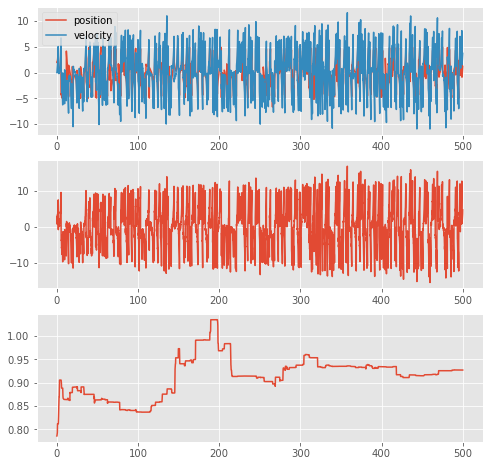

In [4]:
fig, ax = plt.subplots(3, figsize=(8, 8))
ax[0].plot(TH, SAC.tracker.memory['state0'], label='position')
ax[0].plot(TH, SAC.tracker.memory['state1'], label='velocity')
ax[0].legend()
ax[1].plot(TH, SAC.tracker.memory['control'])
ax[2].plot(TH, SAC.tracker.memory['policy_angle'])

In [ ]:
from matplotlib import cm
n=10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
zv = np.zeros((n, n))
zu = np.zeros((n, n))
zq = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        v_val = SAC.SVF.predict(jnp.array([xv[i,j], yv[i,j]]))
        _, u_val = SAC.get_control(jnp.array([xv[i,j], yv[i,j]]))
        q_val = SAC.SQF.predict(jnp.array([xv[i,j], yv[i,j]]), 0)
        zv[i,j] = v_val
        zu[i,j] = u_val
        zq[i,j] = q_val

plt.contourf(xv, yv, zq, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Value function');

### Run batch

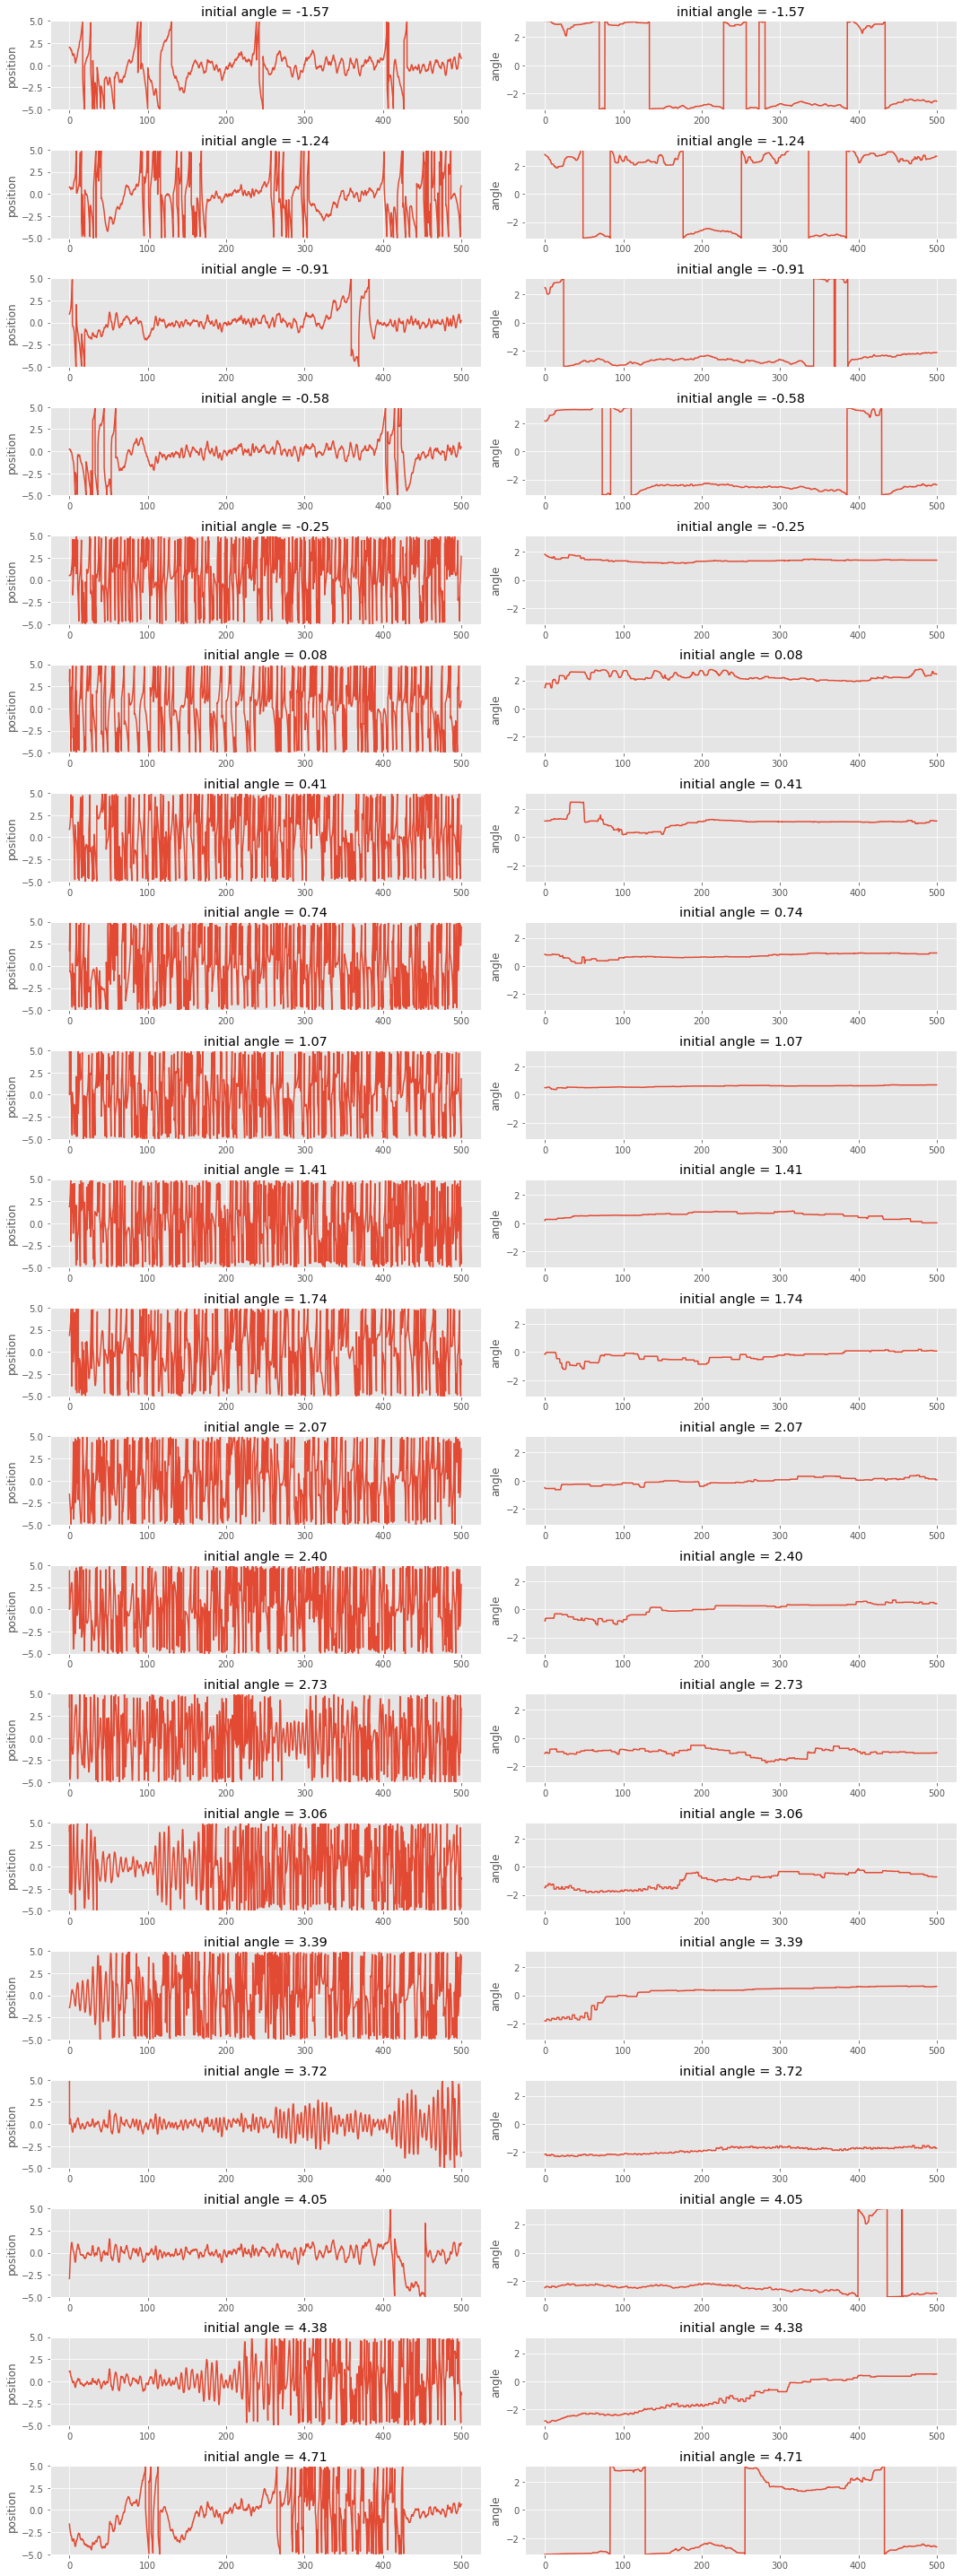

In [13]:
key = jrandom.PRNGKey(1)
key, subkey = jrandom.split(key)

T = 500
n_obs = 2
n_ctrl = 1

# Soft Q-function
Q_act = ['tanh', 'tanh']
Q_dim = (n_obs + n_ctrl, 32, 1) # notice that the control (u) is added
V_act = ['tanh', 'tanh']
V_dim = (n_obs, 32, 1)
PI_dim = (n_obs, n_ctrl)

# Initiate network
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0, boundary=5)

fig, ax = plt.subplots(20, 2, figsize=(15, 40))

for idx, phi in enumerate(np.linspace(-np.pi/2, np.pi*1.5, 20)):
    SAC = SoftActorCritic(key, Q_dim, Q_act, V_dim, V_act, PI_dim)
    SAC.PI.params = jnp.array([[jnp.cos(phi), jnp.sin(phi)]])
    
    _, SAC, TH = run_SAC(key, SDI, SAC, T)

    ax[idx, 0].plot(TH, SAC.tracker.memory['state0'])
    ax[idx, 0].set_ylabel('position')
    ax[idx, 0].set_ylim([-5, 5])
    ax[idx, 1].plot(TH, SAC.tracker.memory['policy_angle'])
    ax[idx, 1].set_ylabel('angle')
    ax[idx, 1].set_ylim([-np.pi, np.pi])
    ax[idx, 0].set_title('initial angle = {:.2f}'.format(phi))
    ax[idx, 1].set_title('initial angle = {:.2f}'.format(phi))
plt.tight_layout()


# BIN

In [ ]:

class SoftQFunction(NeuralNet):
    def __init__(self, key, dimension, activation):
        super().__init__(key, dimension, activation)
        self.gamma = .9
        self.sample_size = 1
    
    def loss(self, D, value_func):
        bellman_residual = 0
        N = len(D)
        for it in range(min(N, self.sample_size)):
            if it == 0:
                s0, u, rew, s1 = D[-1]
            else:
                idx = np.random.randint(0, N)
                s0, u, rew, s1 = D[idx]
            Q = self.predict(s0, u)
            Q_hat = rew + self.gamma * value_func(s1)
            bellman_residual += (Q - Q_hat)**2 / 2
        return bellman_residual / min(N, self.sample_size)
    
    def update(self, D, value_func):
        loss = self.loss(D, value_func)
        grads = self.backpropagation(loss)
        self.update_params(grads)
        return loss
    
    def predict(self, state, control, learning=False, value_output=False):
        input = jnp.hstack([state, control])
        y_hat = self.forward_propagation(input, learning=learning)
        if value_output:
            return y_hat[0,0]
        else:
            return y_hat


class SoftValueFunction(NeuralNet):
    def __init__(self, key, dimension, activation):
        super().__init__(key, dimension, activation)
        self.sample_size = 1
    
    def loss(self, D, q_func, pi_log_func):
        squared_residual_error = 0
        N = len(D)
        for it in range(min(N, self.sample_size)):
            if it == 0:
                s0, u, _, _ = D[-1]
            else:
                idx = np.random.randint(0, N)
                s0, u, _, _ = D[idx]
            V = self.predict(s0)
            # Sample u from policy pi
            Q = q_func(s0, u)
            log_pi = pi_log_func(s0, u)
            squared_residual_error += (V - (Q - log_pi))**2 / 2
        return squared_residual_error / min(N, self.sample_size)

    def update(self, D, q_func, pi_log_func):
        loss = self.loss(D, q_func, pi_log_func)
        grads = self.backpropagation(loss)
        self.update_params(grads)
        return loss


class SoftPolicyFunction:
    def __init__(self, key, dim):
        self.params = jrandom.normal(key, dim).T
        self.stdev = .5
        self.eta = 1e-2
    
    def predict(self, state):
        return jnp.dot(self.params, state)
    
    def get_control(self, state):
        u_star = self.predict(state)
        xi = np.random.normal()
        u = u_star + xi * self.stdev
        return u, u_star
    
    def grad_phi(self, state, control, q_func):
        params = self.params
        grad_phi_log_pi = jax.grad(self.log_pi)(params, state, control)
        grad_u_log_pi = jax.grad(self.log_pi, argnums=2)(params, state, control)
        grad_Q = jax.grad(q_func, argnums=1)(state, control, value_output=True)
        return grad_phi_log_pi + (grad_u_log_pi - grad_Q)*state
    
    def update(self, state, control, q_func):
        grads = self.grad_phi(state, control, q_func)
        self.params += self.eta * grads

    def log_pi(self, params, state, control):
        mu = jnp.dot(stop_gradient(params), state)
        prob = -.5 * ((stop_gradient(control) - mu) / self.stdev)**2 - jnp.log(self.stdev) + jnp.log(2*jnp.pi)/2
        return prob[0]

    def log_prob(self, state, control):
        mu = self.predict(state)
        return -.5 * ((control - mu) / self.stdev)**2 - jnp.log(self.stdev) + jnp.log(2*jnp.pi)/2



In [ ]:
class Tracker:
    def __init__(self, item_list):
        self.memory = {}
        for item in item_list:
            self.memory[item] = list()
    
    def add_item(self, key, item):
        self.memory[key].append(item)
    
    def add(self, item_list, key_list=list()):
        if len(item_list) != len(key_list):
            key_list = self.memory.keys()
        for key, item in zip(key_list, item_list):
            self.add_item(key, item)


class SoftActorCritic:
    def __init__(self, key, q_dim, q_act, v_dim, v_act, pi_dim):
        self.SQF = SoftQFunction(key, q_dim, q_act)
        self.SVF = SoftValueFunction(key, v_dim, v_act)
        self.PI = SoftPolicyFunction(key, pi_dim)
        self.buffer = list()
        self.tracker = Tracker(['state0', 'state1', 'control', 'cost', 'V_value', 'V_loss', 
                                    'Q_value', 'Q_loss', 'policy_angle', 'policy_force'])
    
    def update(self, s0, u, tracking=True):
        v_value = self.SVF.predict(s0, learning=True)[0, 0]
        q_value = self.SQF.predict(s0, u, learning=True)[0, 0]
        v_loss = self.SVF.update(self.buffer, self.SQF.predict, self.PI.log_prob)[0, 0]
        q_loss = self.SQF.update(self.buffer, self.SVF.predict)[0, 0]

        self.PI.update(s0, u, self.SQF.predict)

        if tracking:
            self.tracker.add([s0[0], s0[1], u, None, v_value, v_loss, q_value, q_loss,
                                    None, None])
    
    def get_control(self, state):
        return self.PI.get_control(state)
    
    def add_to_buffer(self, transition):
        self.buffer.append(transition)




In [ ]:
def run_SAC(key, system, controller, T):
    key, subkey = jrandom.split(key)
    time_horizon = np.arange(0, T, system.dt)

    for _ in time_horizon:
        s0_estimate = system.observe(key)
        u, _ = controller.get_control(s0_estimate)
        _, cost, done = system.update(key, u, info=True)
        s1_estimate = system.observe(subkey)
        controller.add_to_buffer((s0_estimate, u, -cost, s1_estimate))

        controller.update(s0_estimate, u)
        
        # step
        key, subkey = jrandom.split(key)

        if done:
            x0 = jrandom.normal(key, (2,))*2
            system.reset(x0)
    
    return system, controller, time_horizon